# Spaceship Titanic
## Predict which passengers are transported to an alternate dimension

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

In [447]:
df = pd.read_csv("DataFile/test.csv")

In [448]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [364]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


### Plot the percentage of NULL values 

In [365]:
def show_null_plot(df):
    null_values = pd.DataFrame(100 * df.isnull().sum() / len(df), columns=["Null %"])
    null_values = null_values[null_values["Null %"] != 0]
    null_values.sort_values(by="Null %", ascending=False, inplace=True)
    plt.figure(figsize=(10, 6), dpi=200)
    sns.barplot(x=null_values.index, y=null_values["Null %"])
    plt.xlabel("Features")
    plt.xticks(rotation=90)
    return null_values.index

Index(['FoodCourt', 'Spa', 'Cabin', 'ShoppingMall', 'Name', 'CryoSleep', 'VIP',
       'Destination', 'Age', 'HomePlanet', 'RoomService', 'VRDeck'],
      dtype='object')

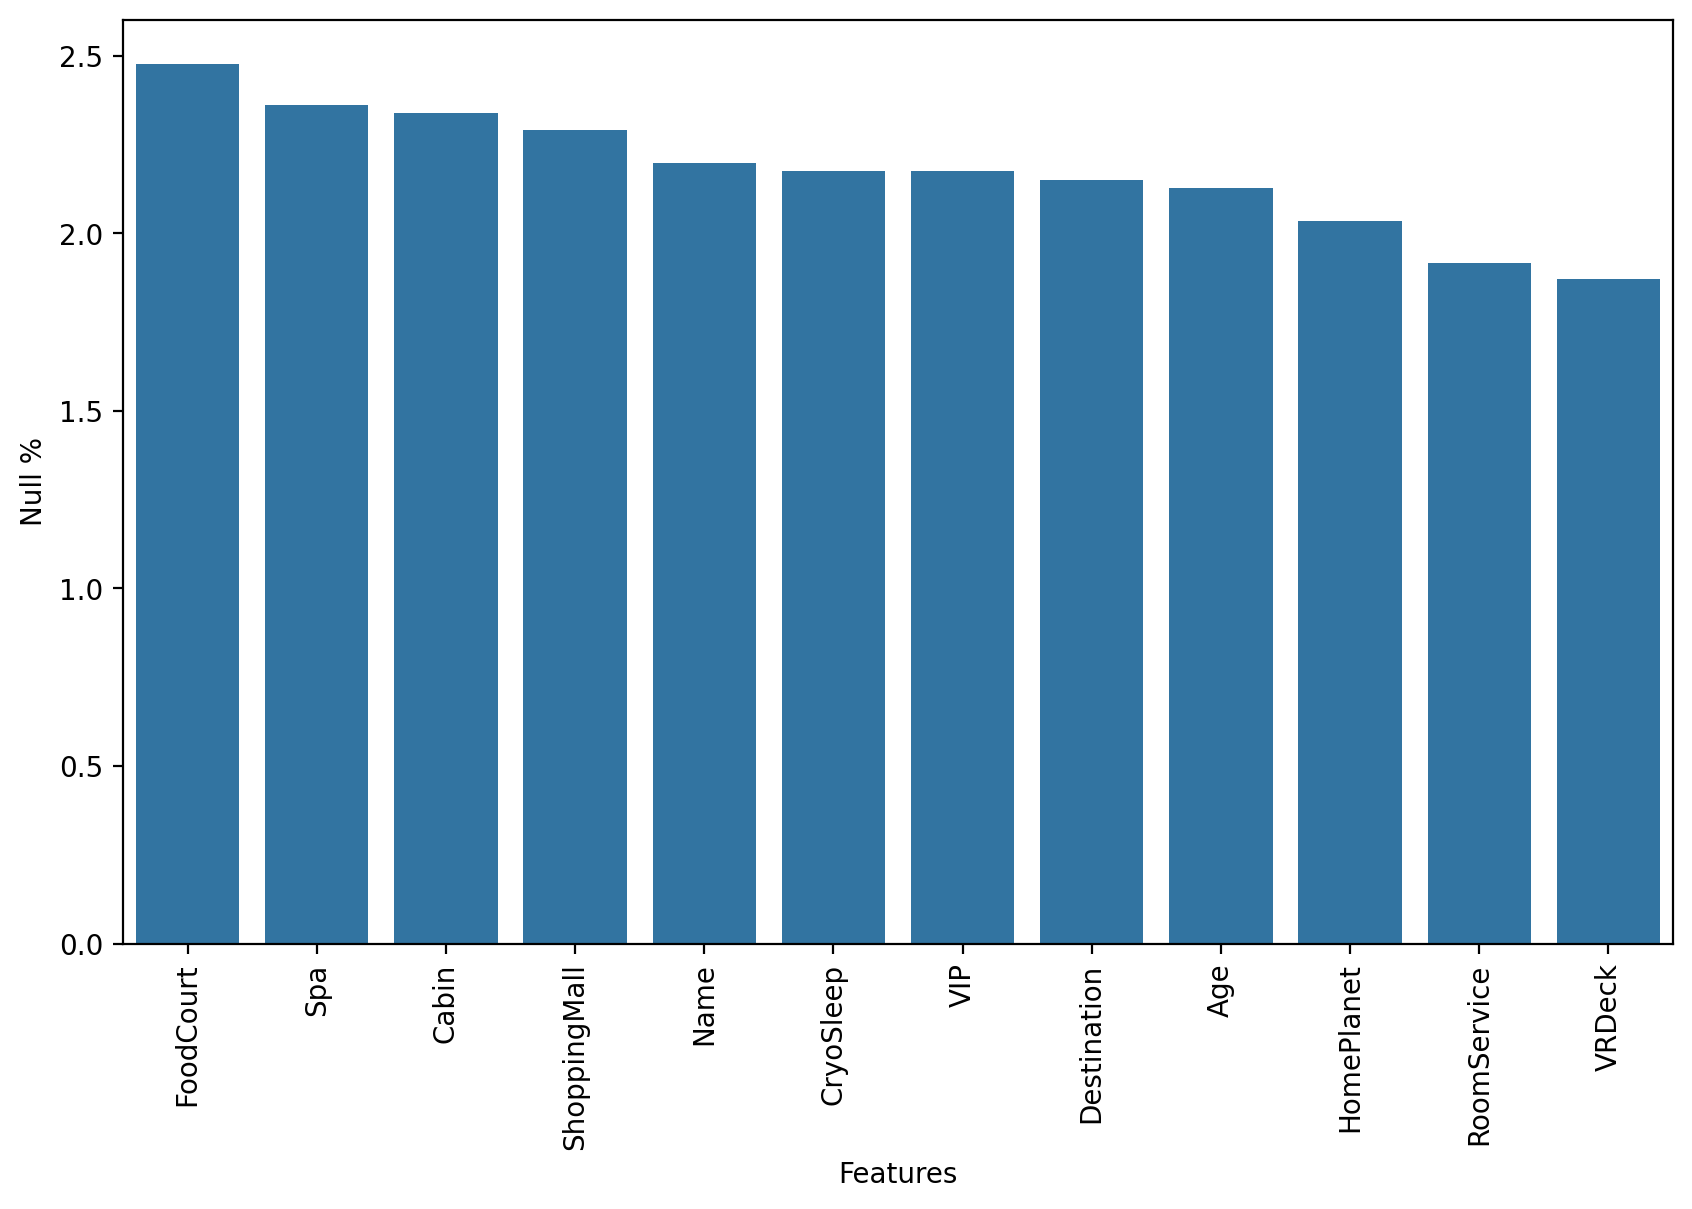

In [366]:
show_null_plot(df)

### Decompose the PassengerId feature into three different categories in order to further analyze

In [367]:
# df["PassengerGroup"] = df["PassengerId"].apply(lambda x: float(x[:-3]))
df.drop("PassengerId", axis=1, inplace=True)

In [368]:
df

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


### Decompose the Cabin feature into three different categories in order to further analyze

In [369]:
df["CabinDeck"] = df["Cabin"].apply(lambda x: x if isinstance(x, float) else x[0])

In [370]:
df["CabinNum"] = df["Cabin"].apply(lambda x: x if isinstance(x, float) else float(x[2:-2])) 

In [371]:
df["CabinSide"] = df["Cabin"].apply(lambda x: x if isinstance(x, float) else x[-1]) 

In [372]:
# these columns are not useful at all
df.drop(["Cabin", "Name", "CabinNum"], axis=1, inplace=True)

In [373]:
df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,G,S
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,F,S
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,C,S
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,C,S
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,G,S
4273,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,NaN,NaN
4274,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,D,P
4275,Europa,False,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,D,P


### Checking for duplicate rows in the dataframe and removing them!

In [374]:
duplicated_df = df[df.duplicated(subset=df.drop(["Transported"], axis=1), keep=False)]

KeyError: "['Transported'] not found in axis"

In [375]:
duplicated_df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinDeck,CabinSide
19,Earth,False,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,True,G,P
36,Europa,True,55 Cancri e,28.0,False,0.0,0.0,0.0,0.0,0.0,True,D,S
41,Earth,True,TRAPPIST-1e,17.0,False,0.0,0.0,0.0,0.0,0.0,True,G,P
43,Earth,True,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,0.0,0.0,False,G,P
44,Earth,True,55 Cancri e,4.0,False,0.0,0.0,0.0,0.0,0.0,True,G,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8676,Earth,True,PSO J318.5-22,22.0,False,0.0,0.0,0.0,0.0,0.0,False,G,P
8680,Earth,True,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,True,G,P
8681,Earth,True,55 Cancri e,33.0,False,0.0,0.0,0.0,0.0,0.0,True,G,S
8685,Europa,False,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,True,A,P


In [216]:
index_duplicated_without_y = duplicated_df.index

In [217]:
duplicated_df[duplicated_df.duplicated(keep=False)]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinDeck,CabinSide
19,Earth,False,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,True,G,P
36,Europa,True,55 Cancri e,28.0,False,0.0,0.0,0.0,0.0,0.0,True,D,S
41,Earth,True,TRAPPIST-1e,17.0,False,0.0,0.0,0.0,0.0,0.0,True,G,P
43,Earth,True,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,0.0,0.0,False,G,P
44,Earth,True,55 Cancri e,4.0,False,0.0,0.0,0.0,0.0,0.0,True,G,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8673,Earth,True,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0,True,G,S
8676,Earth,True,PSO J318.5-22,22.0,False,0.0,0.0,0.0,0.0,0.0,False,G,P
8681,Earth,True,55 Cancri e,33.0,False,0.0,0.0,0.0,0.0,0.0,True,G,S
8685,Europa,False,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,True,A,P


In [218]:
index_duplicated_with_y = duplicated_df[duplicated_df.duplicated(keep=False)].index

In [219]:
index_to_drop = [i for i in index_duplicated_without_y if i not in index_duplicated_with_y]

In [220]:
len(index_to_drop)

185

In [221]:
df.drop(index_to_drop, axis=0, inplace=True)

In [222]:
df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinDeck,CabinSide
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,P
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,S
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,S
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,S


### Checking for the rows with the most Null values in the dataframe

In [223]:
row_nulls_percentage = pd.DataFrame(100 * df.isnull().sum(axis=1) / 15, columns=["Null %"])
rows_indexes = row_nulls_percentage[row_nulls_percentage["Null %"] >= 25].index

In [224]:
rows_indexes

Index([2762, 3882, 6057, 6112], dtype='int64')

In [225]:
df.drop(rows_indexes, axis=0, inplace=True)

Index(['CryoSleep', 'ShoppingMall', 'VIP', 'HomePlanet', 'CabinDeck',
       'CabinSide', 'VRDeck', 'FoodCourt', 'Spa', 'Destination', 'RoomService',
       'Age'],
      dtype='object')

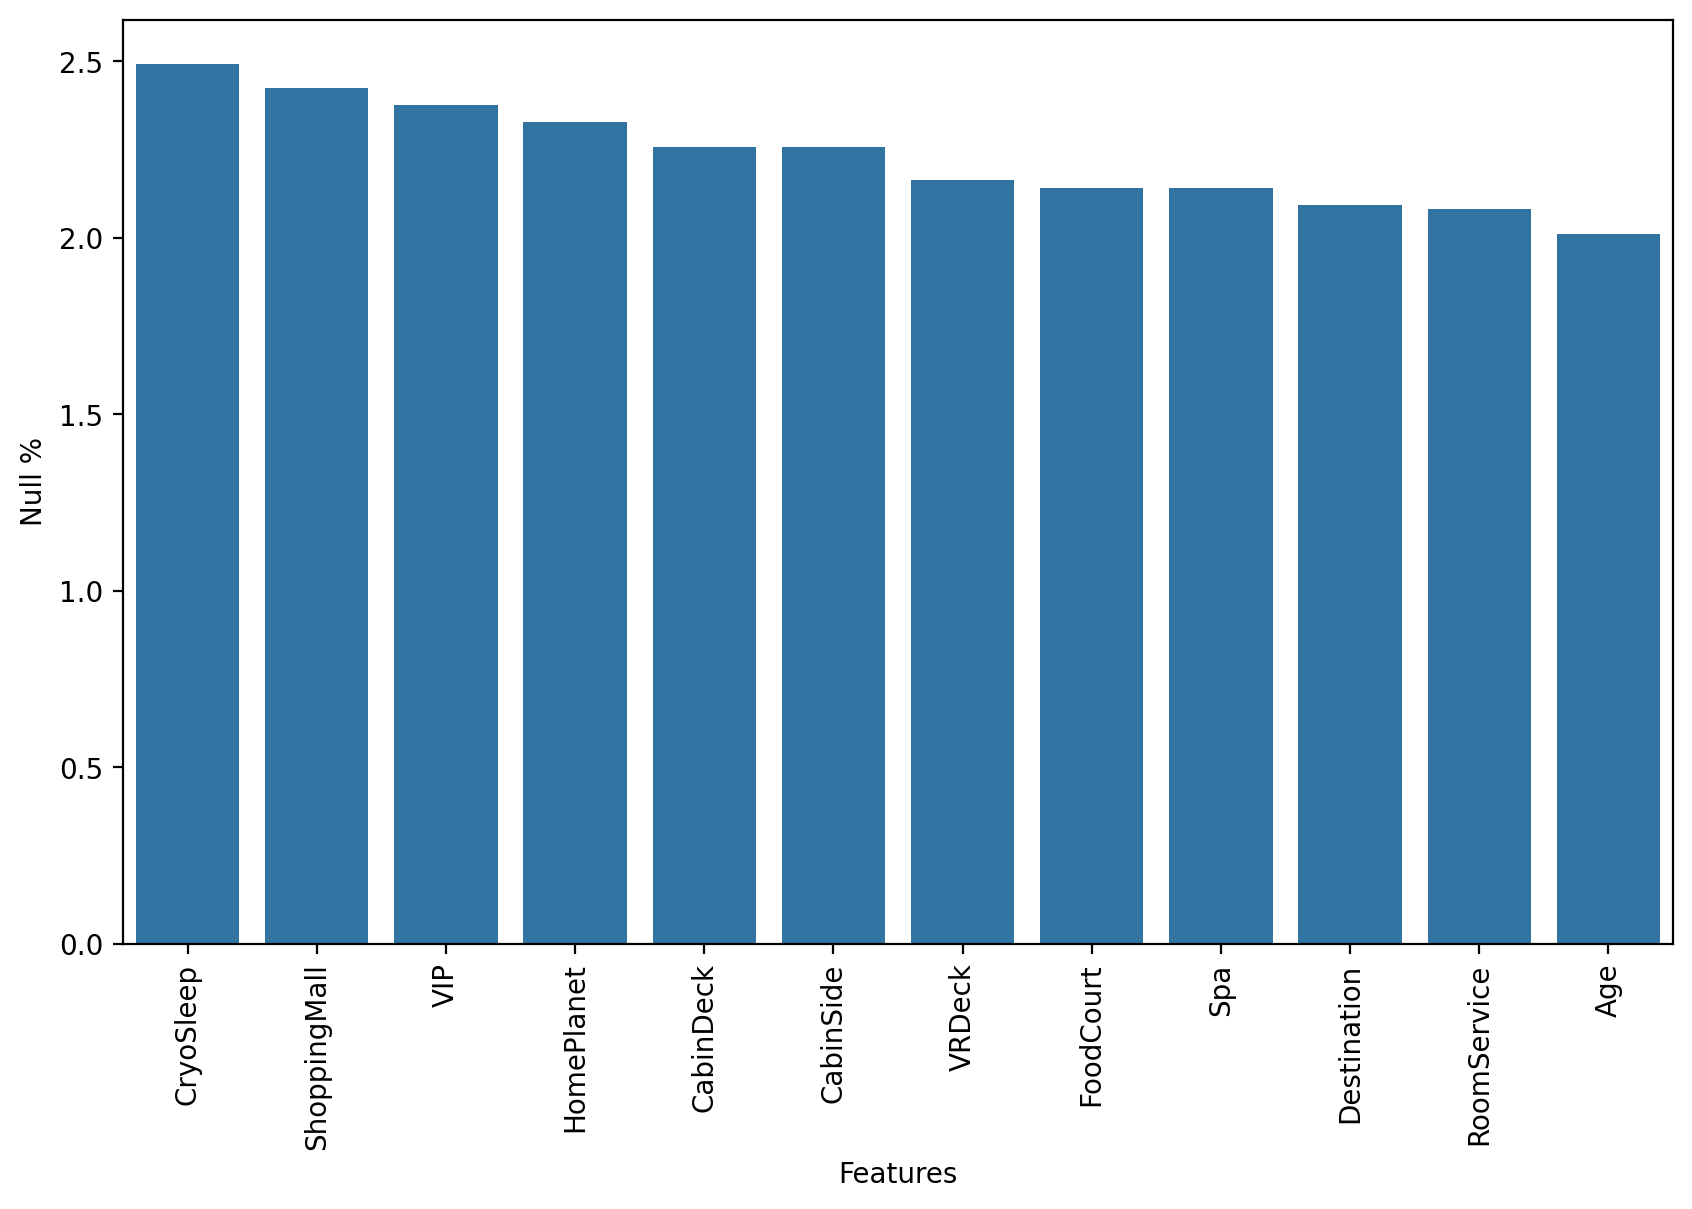

In [226]:
show_null_plot(df)

### Encoding the categorical features into Dummies and Labels 

In [376]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
label_encoded_ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
label_encoded_dummy = OneHotEncoder(handle_unknown='ignore')

In [377]:
columns_to_encodes = [
    "CryoSleep", "VIP", "CabinSide", "CabinDeck", "Transported"
]

In [378]:
object_list = []
for i in df:
    if df[i].dtype == "O":
        object_list.append(i)

In [379]:
columns_to_dummies = [i for i in object_list if i not in columns_to_encodes]

In [380]:
columns_to_dummies

['HomePlanet', 'Destination']

In [381]:
for i in columns_to_encodes:
    df[i] = label_encoded_ordinal.fit_transform(np.array(df[i]).reshape(-1, 1))

KeyError: 'Transported'

In [382]:
dummy_features1 = pd.get_dummies(df["Destination"], dtype=int)
zero_cond = (dummy_features1 == 0).all(axis=1)
dummy_features1[zero_cond] = np.nan

dummy_features2 = pd.get_dummies(df["HomePlanet"], dtype=int)
zero_cond = (dummy_features2 == 0).all(axis=1)
dummy_features2[zero_cond] = np.nan

df.drop(columns_to_dummies, axis=1, inplace=True)
final_df = pd.concat([df, dummy_features1, dummy_features2], axis=1)

In [383]:
final_df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,55 Cancri e,PSO J318.5-22,TRAPPIST-1e,Earth,Europa,Mars
0,1.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,19.0,0.0,0.0,9.0,0.0,2823.0,0.0,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,38.0,0.0,0.0,6652.0,0.0,181.0,585.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,20.0,0.0,10.0,0.0,635.0,0.0,0.0,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4273,0.0,42.0,0.0,0.0,847.0,17.0,10.0,144.0,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0
4274,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4275,0.0,NaN,0.0,0.0,2680.0,0.0,0.0,523.0,3.0,0.0,NaN,NaN,NaN,0.0,1.0,0.0


In [384]:
abs(final_df.corr()["Transported"]).sort_values(ascending=False)

KeyError: 'Transported'

### Now it's time to dealing with the missing values!

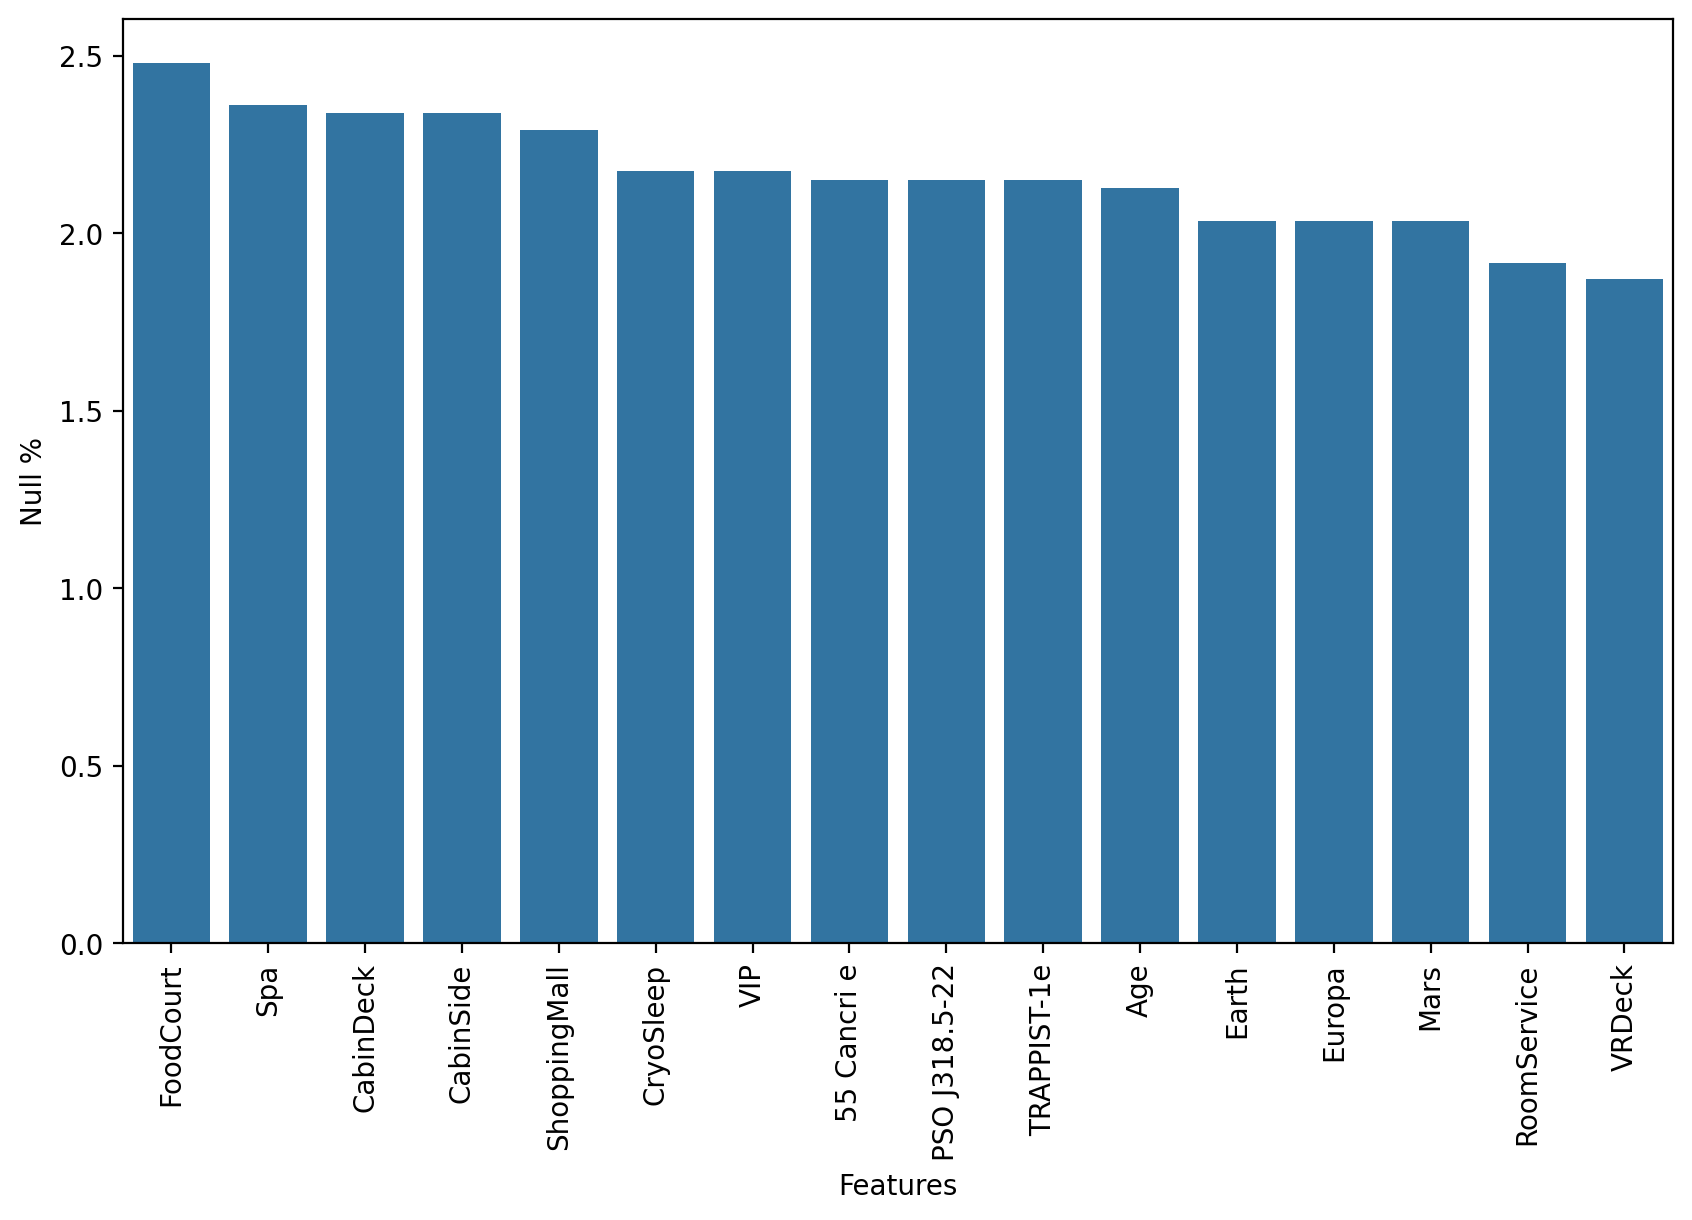

In [385]:
null_columns = show_null_plot(final_df)

In [386]:
null_columns

Index(['FoodCourt', 'Spa', 'CabinDeck', 'CabinSide', 'ShoppingMall',
       'CryoSleep', 'VIP', '55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e',
       'Age', 'Earth', 'Europa', 'Mars', 'RoomService', 'VRDeck'],
      dtype='object')

### We will use KNN imputation to find the missing values for each column in the final data frame

In [387]:
from sklearn.impute import KNNImputer
def imputer(df, null_column, k):
    selected_features = abs(df.corr()[null_column]).sort_values(ascending=False)
    selected_data = df[selected_features.index]
    knn_imputer = KNNImputer(n_neighbors=k)
    imputed_data = knn_imputer.fit_transform(selected_data)
    column_without_null = imputed_data[:, 0]
    df[null_column] = np.round(column_without_null)

    return df

In [388]:
final_df_not_null = final_df.copy()
for i in null_columns:
    final_df_not_null = imputer(final_df_not_null, i, 4)

In [389]:
final_df_not_null

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,55 Cancri e,PSO J318.5-22,TRAPPIST-1e,Earth,Europa,Mars
0,1.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,19.0,0.0,0.0,9.0,0.0,2823.0,0.0,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,38.0,0.0,0.0,6652.0,0.0,181.0,585.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,20.0,0.0,10.0,0.0,635.0,0.0,0.0,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4273,0.0,42.0,0.0,0.0,847.0,17.0,10.0,144.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4274,1.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4275,0.0,40.0,0.0,0.0,2680.0,0.0,0.0,523.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Index([], dtype='object')

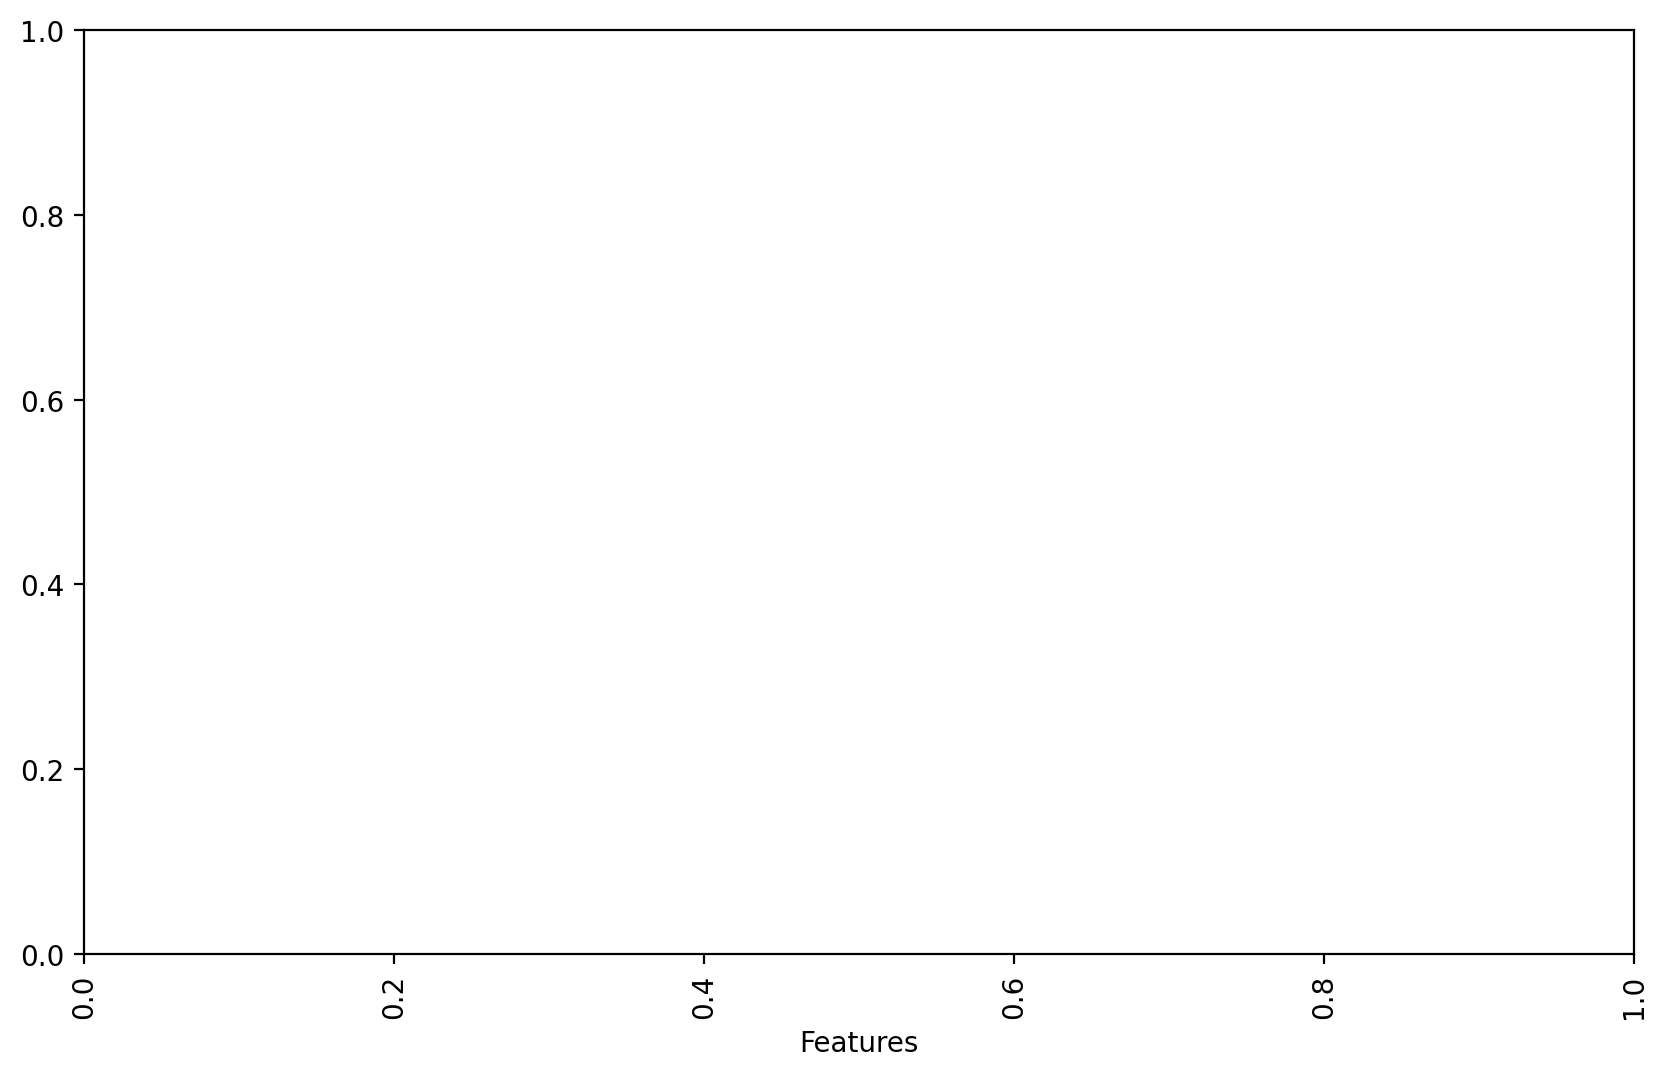

In [390]:
show_null_plot(final_df_not_null)

### Feture Engineering Time!

In [391]:
final_df_not_null["TotalSpent"] = final_df_not_null["RoomService"] + final_df_not_null["FoodCourt"] + final_df_not_null["ShoppingMall"] + final_df_not_null["Spa"] + final_df_not_null["VRDeck"]

In [392]:
final_df_not_null["IsSpent"] = final_df_not_null["TotalSpent"].apply(lambda x: 1 if x > 0 else 0)

In [393]:
def spent_group(x):
    if x == 0:
        return 0 
    if 0 < x <= 754:
        return 1
    elif 754 < x <= 1544:
        return 2
    elif 1544 < x <= 10000:
        return 3
    else:
        return 4

In [394]:
final_df_not_null["SpentGroup"] = final_df_not_null["TotalSpent"].apply(spent_group)

In [395]:
final_df_not_null

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,55 Cancri e,PSO J318.5-22,TRAPPIST-1e,Earth,Europa,Mars,TotalSpent,IsSpent,SpentGroup
0,1.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0
1,0.0,19.0,0.0,0.0,9.0,0.0,2823.0,0.0,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2832.0,1,3
2,1.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0
3,0.0,38.0,0.0,0.0,6652.0,0.0,181.0,585.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,7418.0,1,3
4,0.0,20.0,0.0,10.0,0.0,635.0,0.0,0.0,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,645.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0
4273,0.0,42.0,0.0,0.0,847.0,17.0,10.0,144.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1018.0,1,2
4274,1.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
4275,0.0,40.0,0.0,0.0,2680.0,0.0,0.0,523.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3203.0,1,3


In [396]:
final_df_not_null["RoomService"].describe()

count     4277.000000
mean       220.969371
std        604.125924
min          0.000000
25%          0.000000
50%          0.000000
75%         59.000000
max      11567.000000
Name: RoomService, dtype: float64

<Axes: xlabel='RoomService', ylabel='Count'>

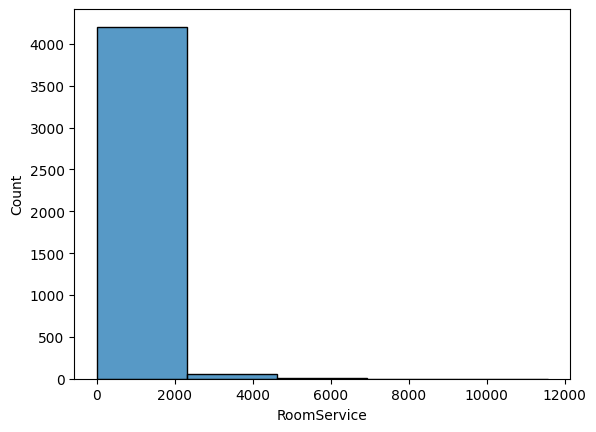

In [397]:
sns.histplot(data=final_df_not_null, x="RoomService", bins=5)

In [398]:
def room_spent_group(x):
    if x == 0:
        return 0
    # elif 0 < x < 230:
    #     return 1
    else:
        return 1

In [399]:
final_df_not_null["RoomServiceGroup"] = final_df_not_null["RoomService"].apply(room_spent_group)

In [400]:
final_df_not_null["FoodCourt"].describe()

count     4277.000000
mean       435.735796
std       1513.563584
min          0.000000
25%          0.000000
50%          0.000000
75%         83.000000
max      25273.000000
Name: FoodCourt, dtype: float64

<Axes: xlabel='FoodCourt', ylabel='Count'>

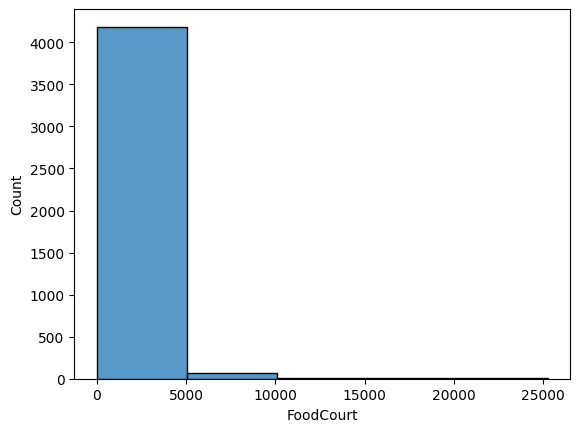

In [401]:
sns.histplot(data=final_df_not_null, x="FoodCourt", bins=5)

In [402]:
def food_spent_group(x):
    if x == 0:
        return 0
    # elif 0 < x < 465:
    #     return 1
    else:
        return 1

In [403]:
final_df_not_null["FoodCourtGroup"] = final_df_not_null["FoodCourt"].apply(food_spent_group)

In [404]:
final_df_not_null["ShoppingMall"].describe()

count    4277.000000
mean      175.774608
std       555.552267
min         0.000000
25%         0.000000
50%         0.000000
75%        36.000000
max      8292.000000
Name: ShoppingMall, dtype: float64

<Axes: xlabel='ShoppingMall', ylabel='Count'>

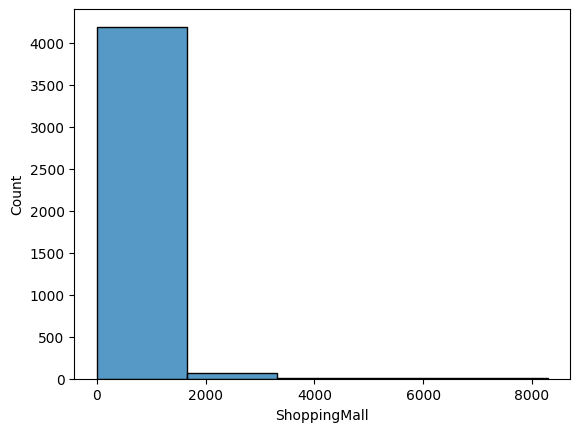

In [405]:
sns.histplot(data=final_df_not_null, x="ShoppingMall", bins=5)

In [406]:
def shopping_spent_group(x):
    if x == 0:
        return 0
    # elif 0 < x < 176:
    #     return 1
    else:
        return 1

In [407]:
final_df_not_null["ShoppingMallGroup"] = final_df_not_null["ShoppingMall"].apply(shopping_spent_group)

In [408]:
final_df_not_null["Spa"].describe()

count     4277.000000
mean       299.886369
std       1105.853517
min          0.000000
25%          0.000000
50%          0.000000
75%         50.000000
max      19844.000000
Name: Spa, dtype: float64

<Axes: xlabel='Spa', ylabel='Count'>

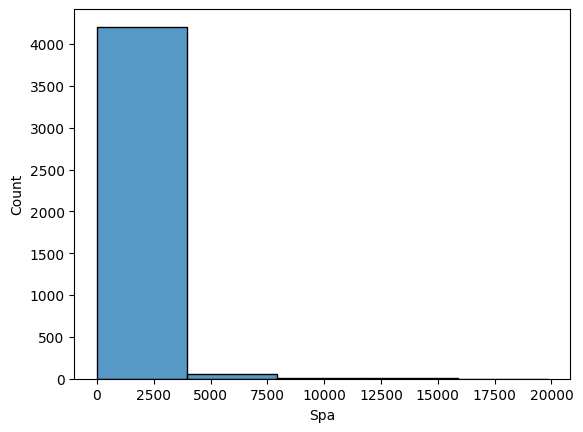

In [409]:
sns.histplot(data=final_df_not_null, x="Spa", bins=5)

In [410]:
def spa_spent_group(x):
    if x == 0:
        return 0
    # elif 0 < x < 319:
    #     return 1
    else:
        return 1

In [411]:
final_df_not_null["SpaGroup"] = final_df_not_null["Spa"].apply(spa_spent_group)

In [412]:
final_df_not_null[final_df_not_null["VRDeck"] > 0]["VRDeck"].describe()

count     1476.000000
mean       901.067073
std       1980.021151
min          1.000000
25%         29.000000
50%        246.500000
75%        817.250000
max      22272.000000
Name: VRDeck, dtype: float64

<Axes: xlabel='VRDeck', ylabel='Count'>

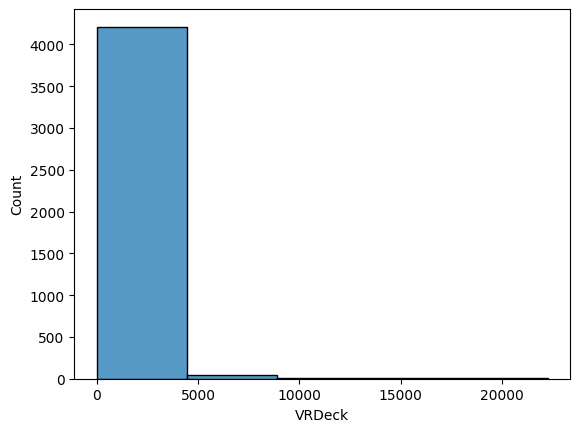

In [413]:
sns.histplot(data=final_df_not_null, x="VRDeck", bins=5)

In [414]:
def vrdeck_spent_group(x):
    if x == 0:
        return 0
    # elif 0 < x < 308:
    #     return 1
    else:
        return 1

In [415]:
final_df_not_null["VRDeckGroup"] = final_df_not_null["VRDeck"].apply(vrdeck_spent_group)

In [416]:
final_df_not_null

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,...,Europa,Mars,TotalSpent,IsSpent,SpentGroup,RoomServiceGroup,FoodCourtGroup,ShoppingMallGroup,SpaGroup,VRDeckGroup
0,1.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,0.0,19.0,0.0,0.0,9.0,0.0,2823.0,0.0,5.0,1.0,...,0.0,0.0,2832.0,1,3,0,1,0,1,0
2,1.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,...,1.0,0.0,0.0,0,0,0,0,0,0,0
3,0.0,38.0,0.0,0.0,6652.0,0.0,181.0,585.0,2.0,1.0,...,1.0,0.0,7418.0,1,3,0,1,0,1,1
4,0.0,20.0,0.0,10.0,0.0,635.0,0.0,0.0,5.0,1.0,...,0.0,0.0,645.0,1,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4273,0.0,42.0,0.0,0.0,847.0,17.0,10.0,144.0,5.0,0.0,...,0.0,0.0,1018.0,1,2,0,1,1,1,1
4274,1.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,1.0,0.0,0,0,0,0,0,0,0
4275,0.0,40.0,0.0,0.0,2680.0,0.0,0.0,523.0,3.0,0.0,...,1.0,0.0,3203.0,1,3,0,1,0,0,1


### Standardize the numerical columns

In [417]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

final_df_not_null["RoomService"] = scalar.fit_transform(final_df_not_null["RoomService"].to_numpy().reshape(-1, 1))
final_df_not_null["FoodCourt"] = scalar.fit_transform(final_df_not_null["FoodCourt"].to_numpy().reshape(-1, 1))
final_df_not_null["Spa"] = scalar.fit_transform(final_df_not_null["Spa"].to_numpy().reshape(-1, 1))
final_df_not_null["ShoppingMall"] = scalar.fit_transform(final_df_not_null["ShoppingMall"].to_numpy().reshape(-1, 1))
final_df_not_null["VRDeck"] = scalar.fit_transform(final_df_not_null["VRDeck"].to_numpy().reshape(-1, 1))
final_df_not_null["TotalSpent"] = scalar.fit_transform(final_df_not_null["TotalSpent"].to_numpy().reshape(-1, 1))

### Looking at some graphs!

<Axes: xlabel='SpentGroup', ylabel='count'>

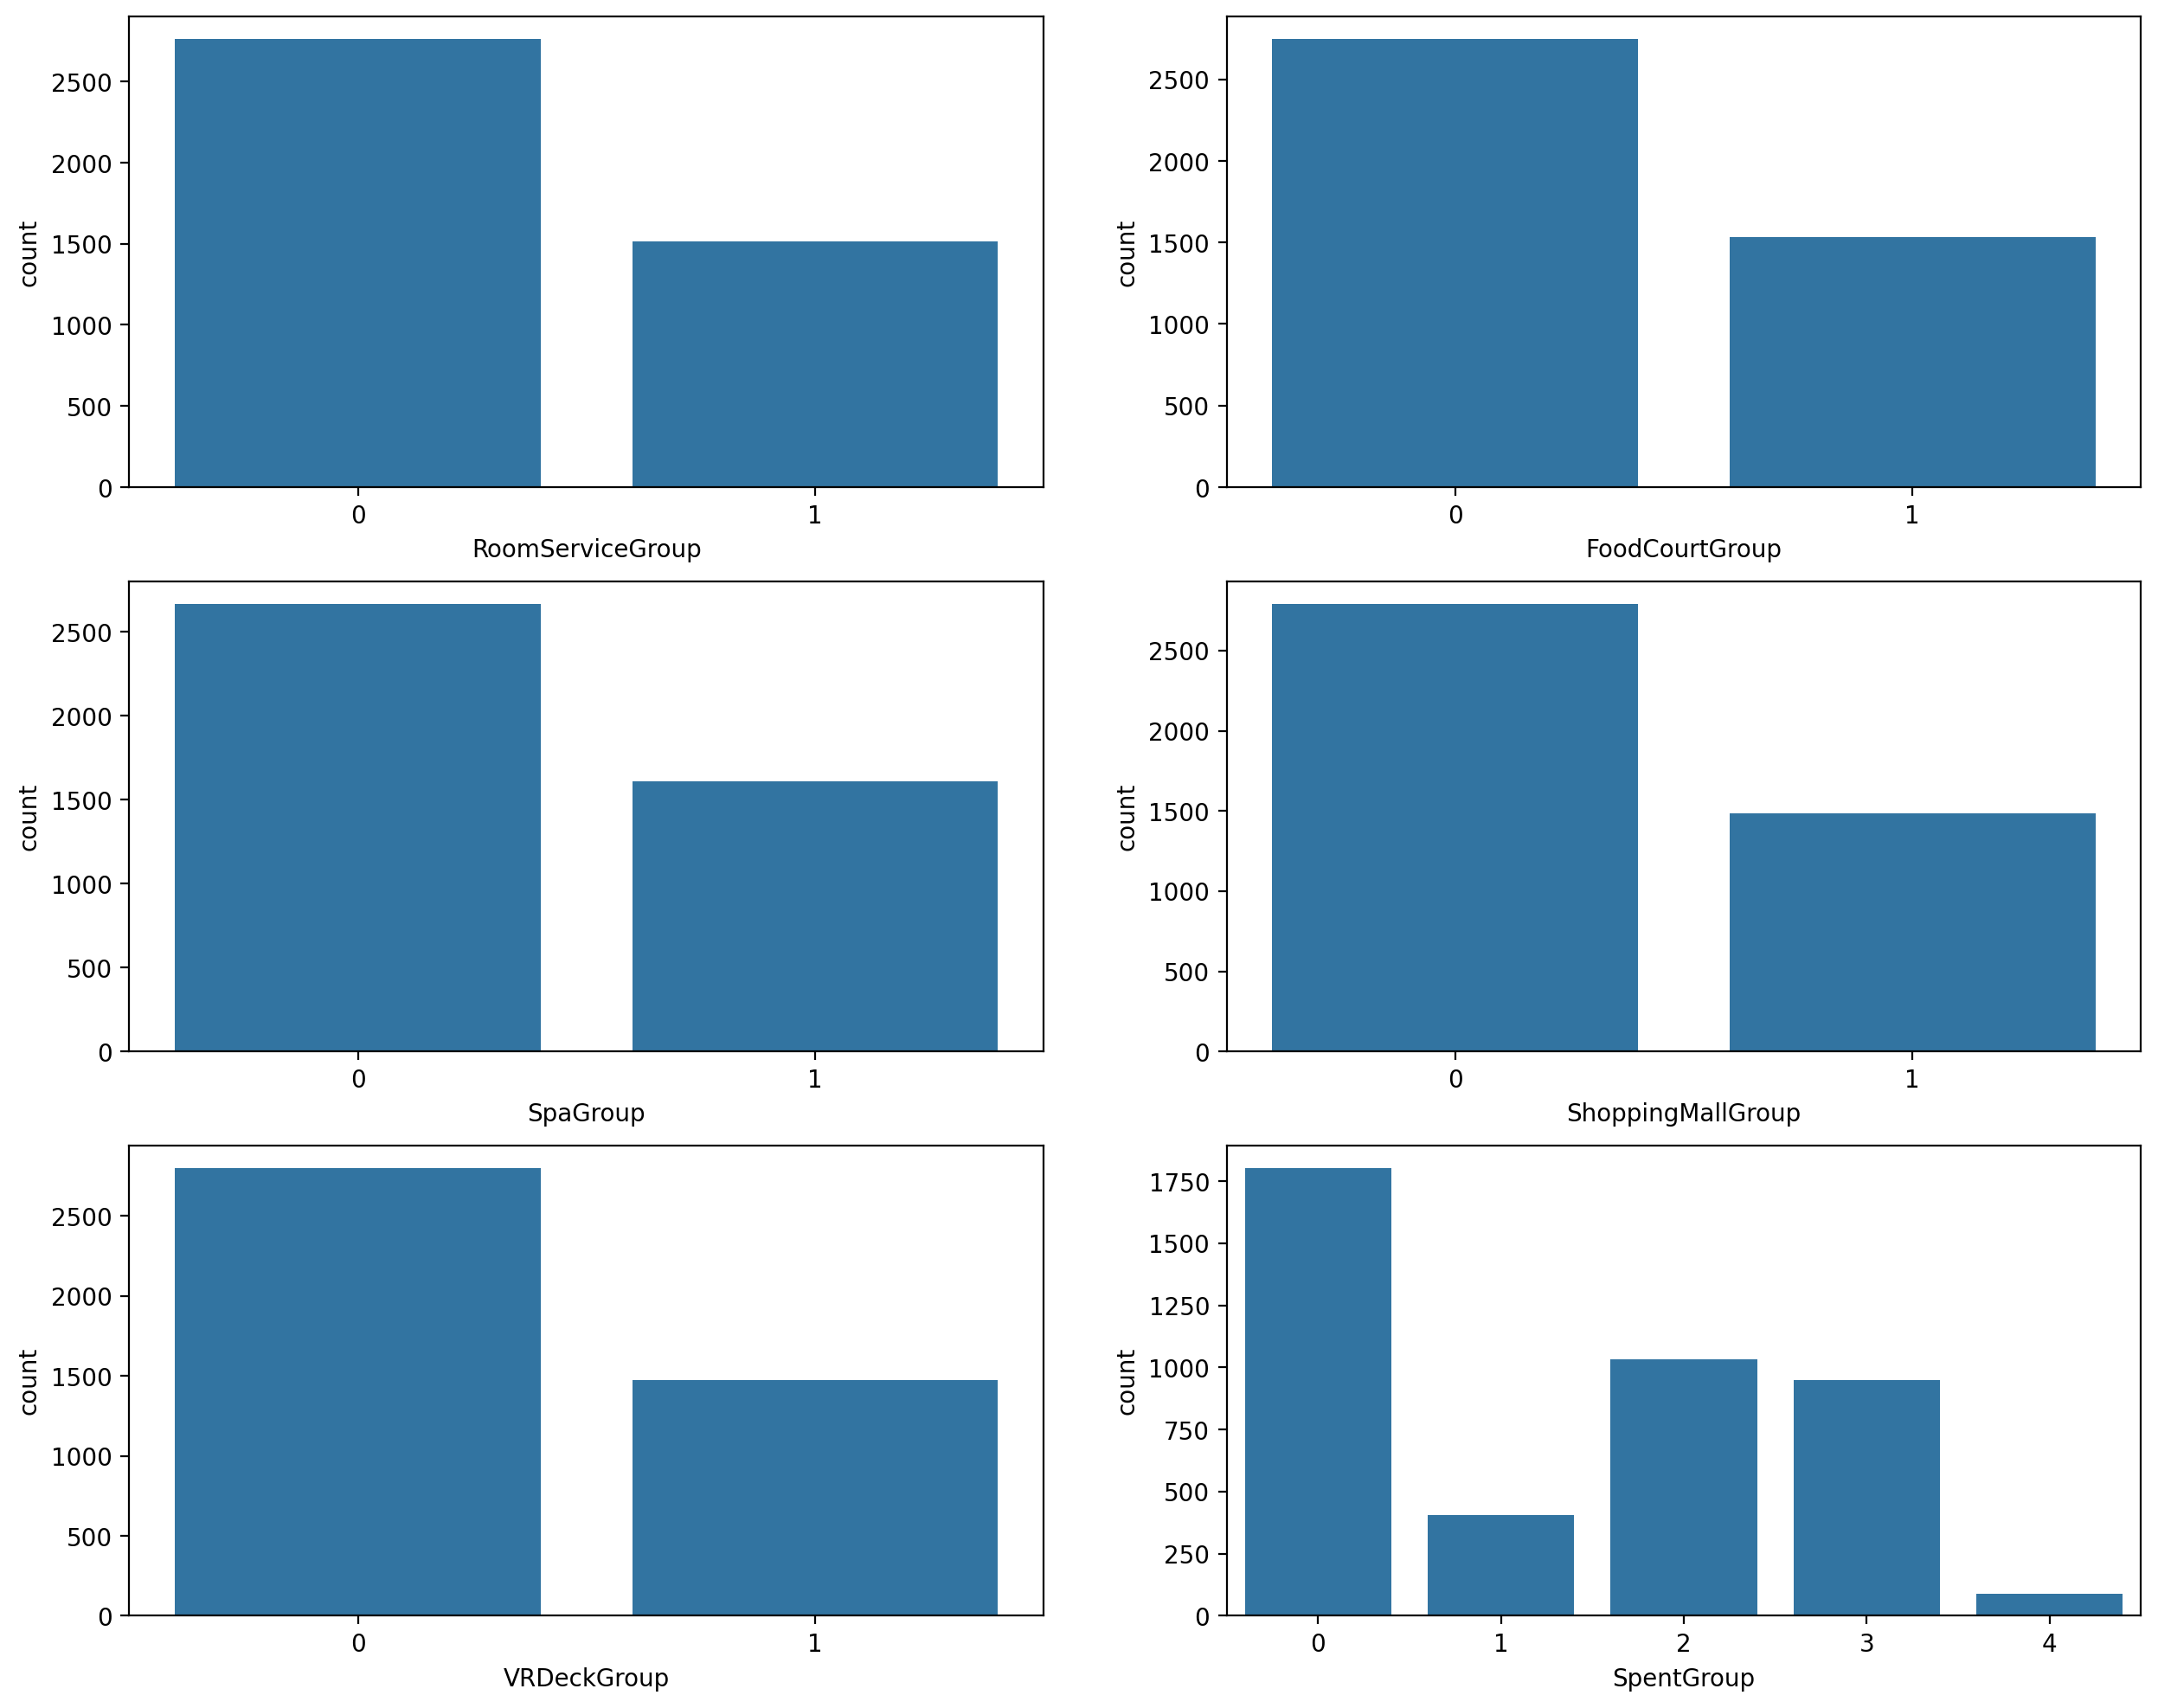

In [418]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12), dpi=200)
sns.countplot(data=final_df_not_null, x="RoomServiceGroup", ax=axes[0, 0])
sns.countplot(data=final_df_not_null, x="FoodCourtGroup", ax=axes[0, 1])
sns.countplot(data=final_df_not_null, x="SpaGroup", ax=axes[1, 0])
sns.countplot(data=final_df_not_null, x="ShoppingMallGroup", ax=axes[1, 1])
sns.countplot(data=final_df_not_null, x="VRDeckGroup", ax=axes[2, 0])
sns.countplot(data=final_df_not_null, x="SpentGroup", ax=axes[2, 1])

### Now it's time to find the correlation between the features and plot the Heat map

In [312]:
# final_df_not_null.drop("PassengerGroup", axis=1, inplace=True)
correlation = abs(final_df_not_null.corr()["Transported"]).sort_values(ascending=False)

In [313]:
correlation

Transported          1.000000
IsSpent              0.501289
CryoSleep            0.485745
SpentGroup           0.438445
RoomServiceGroup     0.367340
SpaGroup             0.363226
VRDeckGroup          0.345937
ShoppingMallGroup    0.281955
RoomService          0.249954
FoodCourtGroup       0.248862
Spa                  0.225413
VRDeck               0.209895
TotalSpent           0.208830
Europa               0.181681
Earth                0.174498
CabinDeck            0.116296
55 Cancri e          0.112323
CabinSide            0.109122
TRAPPIST-1e          0.100698
Age                  0.076123
FoodCourt            0.042873
VIP                  0.038602
Mars                 0.023953
PSO J318.5-22        0.007456
ShoppingMall         0.005131
Name: Transported, dtype: float64

<Axes: >

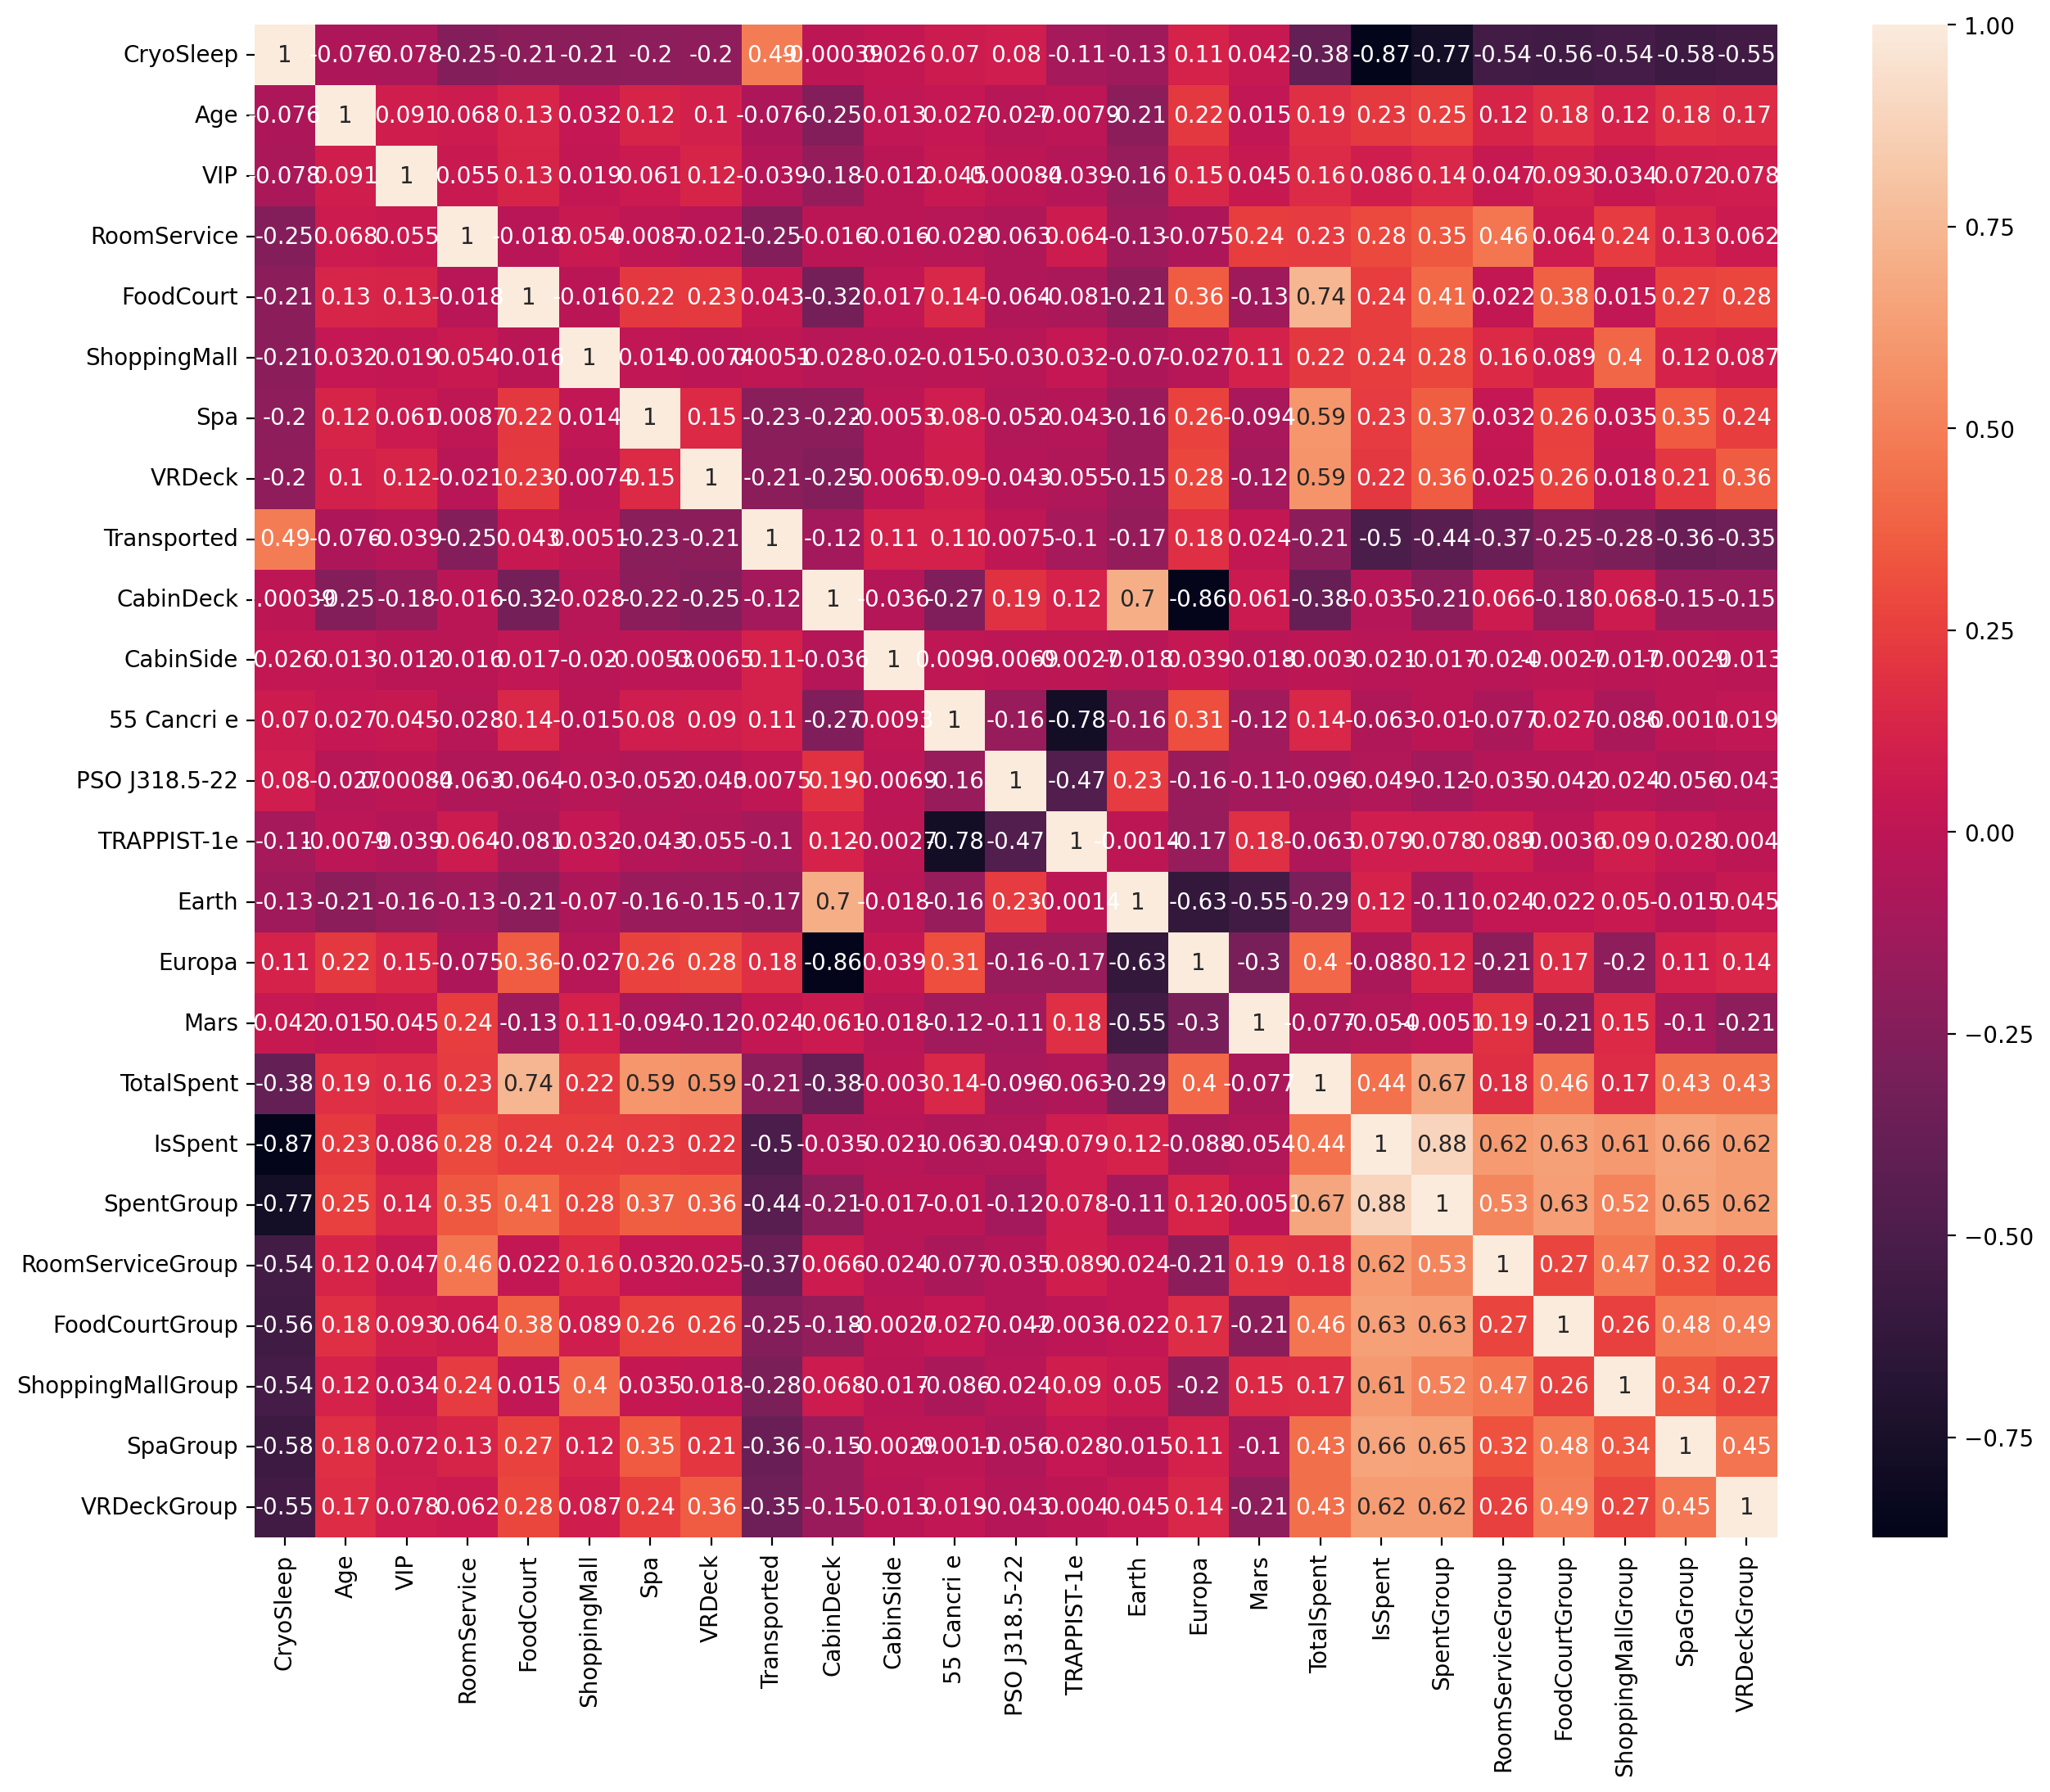

In [315]:
plt.figure(figsize=(15, 12), dpi=200)
sns.heatmap(final_df_not_null.corr(), annot=True)

In [316]:
final_df_not_null

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinDeck,...,Europa,Mars,TotalSpent,IsSpent,SpentGroup,RoomServiceGroup,FoodCourtGroup,ShoppingMallGroup,SpaGroup,VRDeckGroup
0,0.0,39.0,0.0,-0.343078,-0.288233,-0.291594,-0.279351,-0.268285,0.0,1.0,...,1.0,0.0,-0.527826,0,0,0,0,0,0,0
1,0.0,24.0,0.0,-0.180460,-0.282662,-0.250242,0.202556,-0.229903,1.0,5.0,...,0.0,0.0,-0.268451,1,1,1,1,1,1,1
2,0.0,58.0,1.0,-0.278926,1.924984,-0.291594,5.615015,-0.225541,0.0,0.0,...,1.0,0.0,3.131271,1,4,1,1,0,1,1
3,0.0,33.0,0.0,-0.343078,0.505827,0.322067,2.642815,-0.099925,0.0,0.0,...,1.0,0.0,1.296260,1,3,0,1,1,1,1
4,0.0,16.0,0.0,0.108970,-0.244909,-0.041829,0.216600,-0.266541,1.0,5.0,...,0.0,0.0,-0.143344,1,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,41.0,1.0,-0.343078,3.932104,-0.291594,1.162859,-0.203732,0.0,0.0,...,1.0,0.0,2.480366,1,3,0,1,0,1,1
8689,1.0,18.0,0.0,-0.343078,-0.288233,-0.291594,-0.279351,-0.268285,0.0,6.0,...,0.0,0.0,-0.527826,0,0,0,0,0,0,0
8690,0.0,26.0,0.0,-0.343078,-0.288233,2.804831,-0.278474,-0.268285,1.0,6.0,...,0.0,0.0,0.132242,1,3,0,0,1,1,0
8691,0.0,32.0,0.0,-0.343078,0.361002,-0.291594,0.030509,2.553721,0.0,4.0,...,1.0,0.0,1.106310,1,3,0,1,0,1,1


In [317]:
final_df_not_null[final_df_not_null.duplicated()]

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinDeck,...,Europa,Mars,TotalSpent,IsSpent,SpentGroup,RoomServiceGroup,FoodCourtGroup,ShoppingMallGroup,SpaGroup,VRDeckGroup
169,1.0,2.0,0.0,-0.343078,-0.288233,-0.291594,-0.279351,-0.268285,1.0,5.0,...,0.0,1.0,-0.527826,0,0,0,0,0,0,0
196,1.0,2.0,0.0,-0.343078,-0.288233,-0.291594,-0.279351,-0.268285,1.0,6.0,...,0.0,0.0,-0.527826,0,0,0,0,0,0,0
197,0.0,0.0,0.0,-0.343078,-0.288233,-0.291594,-0.279351,-0.268285,1.0,6.0,...,0.0,0.0,-0.527826,0,0,0,0,0,0,0
202,1.0,15.0,0.0,-0.343078,-0.288233,-0.291594,-0.279351,-0.268285,1.0,6.0,...,0.0,0.0,-0.527826,0,0,0,0,0,0,0
223,1.0,35.0,0.0,-0.343078,-0.288233,-0.291594,-0.279351,-0.268285,1.0,5.0,...,0.0,1.0,-0.527826,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8676,1.0,22.0,0.0,-0.343078,-0.288233,-0.291594,-0.279351,-0.268285,0.0,6.0,...,0.0,0.0,-0.527826,0,0,0,0,0,0,0
8681,1.0,33.0,0.0,-0.343078,-0.288233,-0.291594,-0.279351,-0.268285,1.0,6.0,...,0.0,0.0,-0.527826,0,0,0,0,0,0,0
8684,1.0,23.0,0.0,-0.343078,-0.288233,-0.291594,-0.279351,-0.268285,1.0,6.0,...,0.0,0.0,-0.527826,0,0,0,0,0,0,0
8685,0.0,0.0,0.0,-0.343078,-0.288233,-0.291594,-0.279351,-0.268285,1.0,0.0,...,1.0,0.0,-0.527826,0,0,0,0,0,0,0


In [776]:
# final_df_not_null.drop_duplicates(inplace=True)

In [777]:
# final_df_not_null[final_df_not_null.duplicated(subset=final_df_not_null.drop(["Transported"], axis=1))]

In [677]:
# final_df_not_null.drop_duplicates(subset=final_df_not_null.drop_duplicates().drop("Transported", axis=1), inplace=True)

# Data Analysis

<Axes: xlabel='CryoSleep', ylabel='count'>

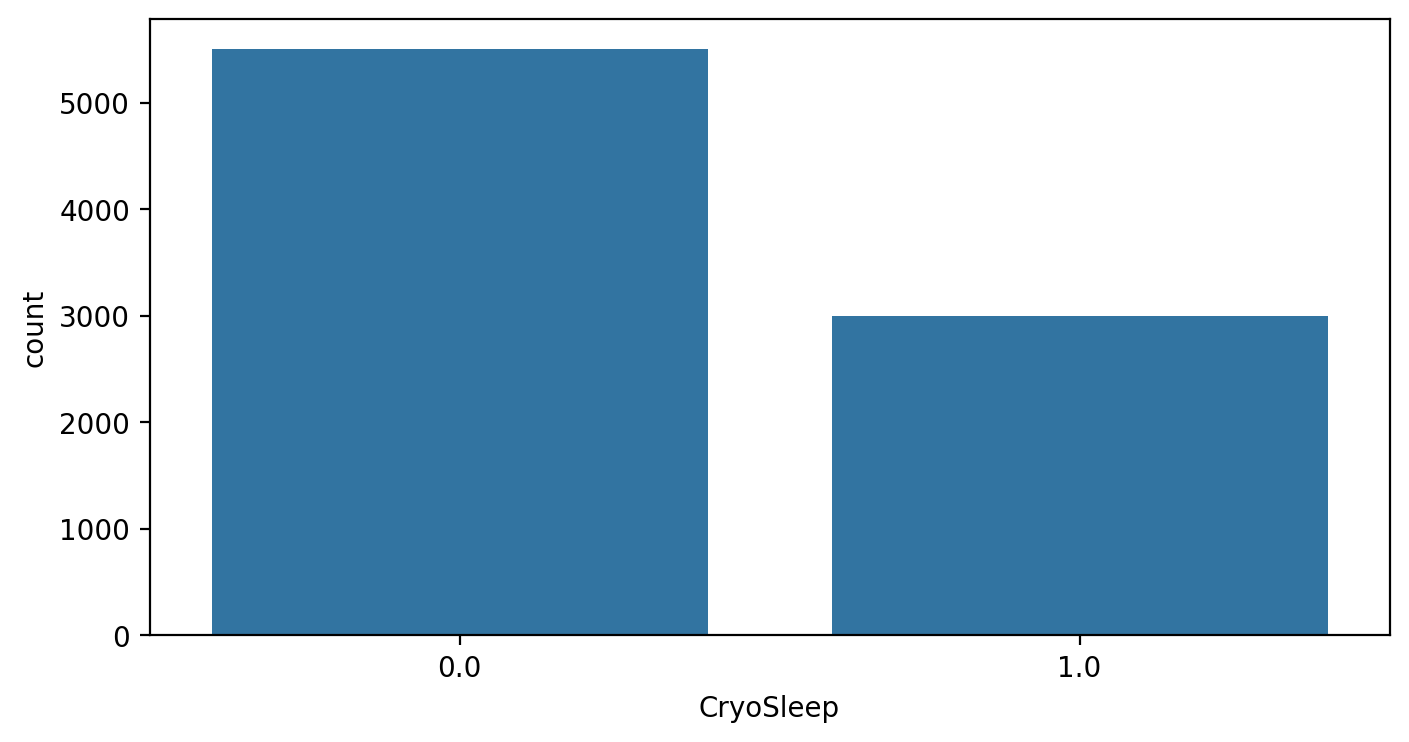

In [318]:
plt.figure(figsize=(8, 4), dpi=200)
sns.countplot(data=final_df_not_null, x="CryoSleep")

<Axes: ylabel='TotalSpent'>

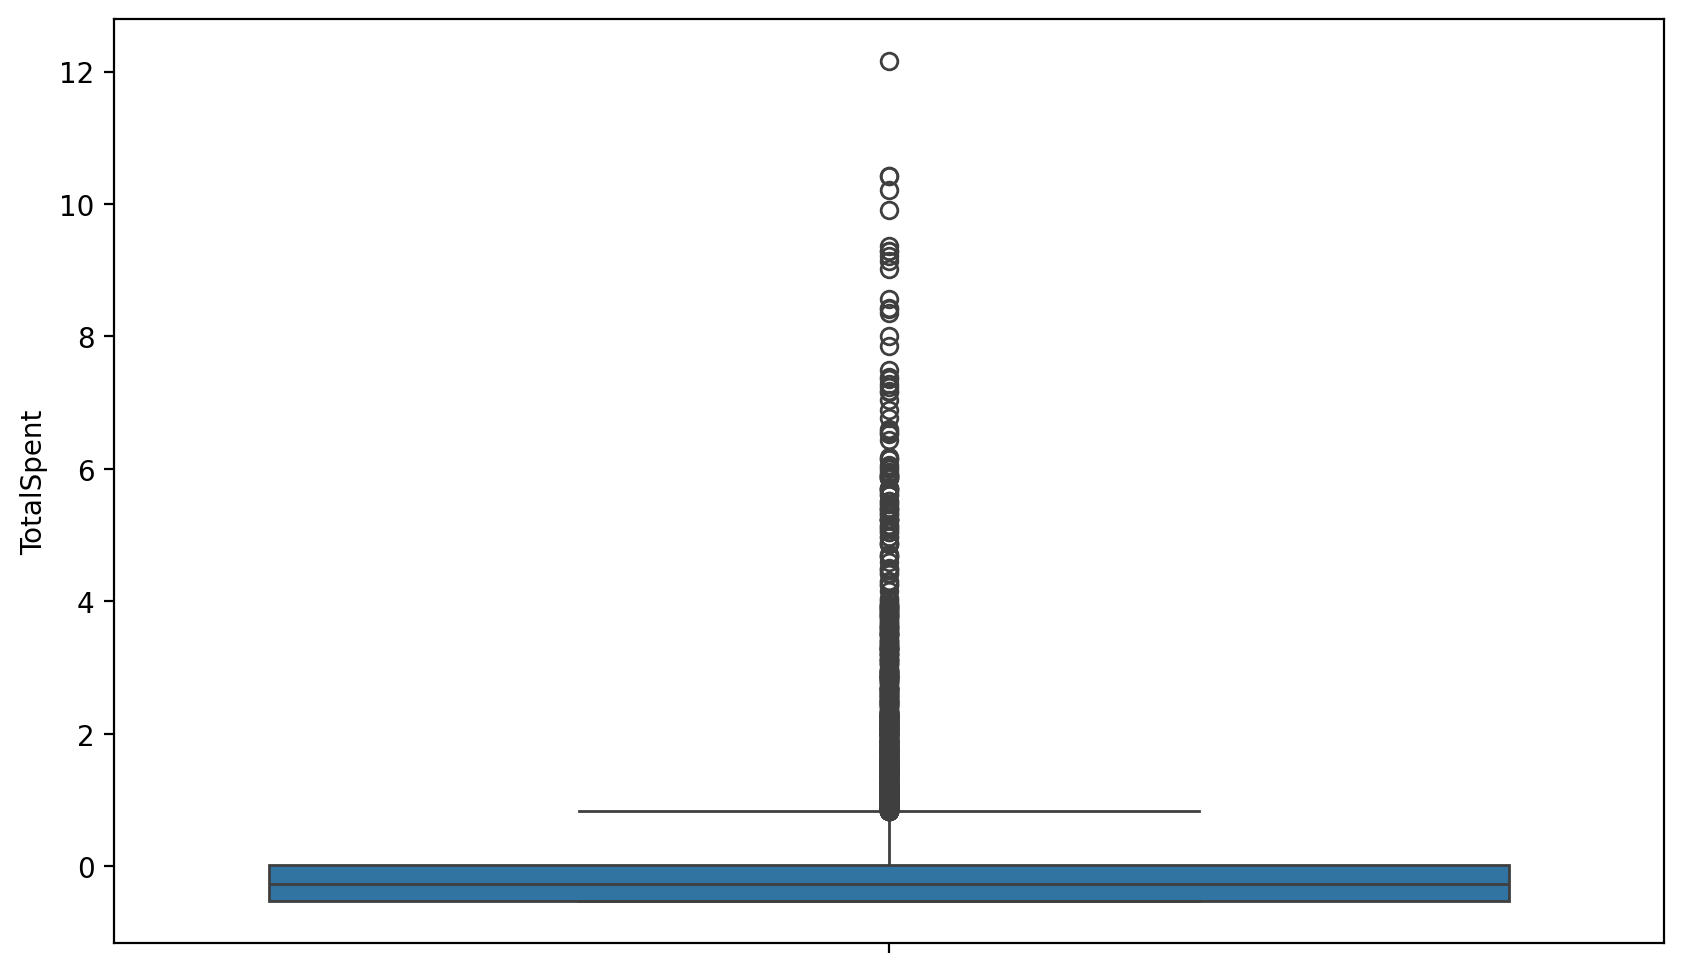

In [319]:
plt.figure(figsize=(10, 6), dpi=200)
sns.boxplot(data=final_df_not_null, y="TotalSpent")

In [320]:
final_df_not_null["TotalSpent"].describe()

count    8.504000e+03
mean    -3.968812e-17
std      1.000059e+00
min     -5.278260e-01
25%     -5.278260e-01
50%     -2.624595e-01
75%      1.603435e-02
max      1.215444e+01
Name: TotalSpent, dtype: float64

<Axes: xlabel='Age', ylabel='Count'>

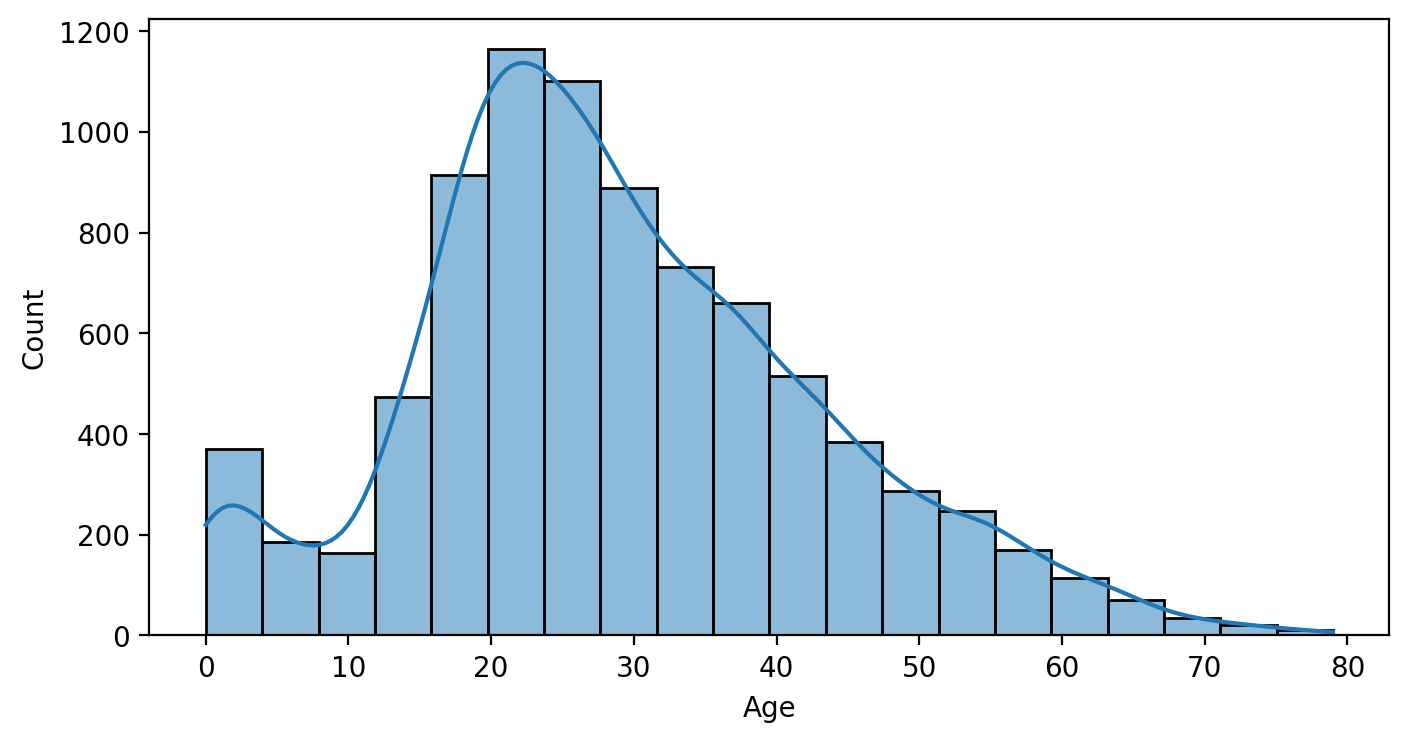

In [322]:
plt.figure(figsize=(8, 4), dpi=200)
sns.histplot(data=final_df_not_null, x="Age", bins=20, kde=True)

<Axes: xlabel='Transported', ylabel='count'>

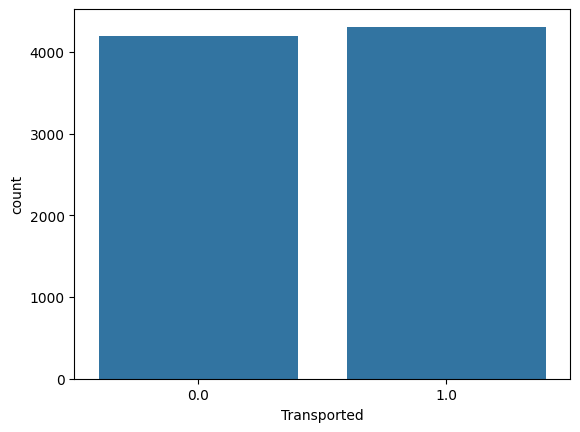

In [323]:
sns.countplot(data=final_df_not_null, x="Transported")

In [419]:
imp_features = correlation[correlation > 0]

In [420]:
imp_features

Transported          1.000000
IsSpent              0.501289
CryoSleep            0.485745
SpentGroup           0.438445
RoomServiceGroup     0.367340
SpaGroup             0.363226
VRDeckGroup          0.345937
ShoppingMallGroup    0.281955
RoomService          0.249954
FoodCourtGroup       0.248862
Spa                  0.225413
VRDeck               0.209895
TotalSpent           0.208830
Europa               0.181681
Earth                0.174498
CabinDeck            0.116296
55 Cancri e          0.112323
CabinSide            0.109122
TRAPPIST-1e          0.100698
Age                  0.076123
FoodCourt            0.042873
VIP                  0.038602
Mars                 0.023953
PSO J318.5-22        0.007456
ShoppingMall         0.005131
Name: Transported, dtype: float64

# Developing ML models to predict the Transported people

In [326]:
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

In [722]:
final_df_not_null.to_csv("final_dataset.csv")

In [421]:
x_test = final_df_not_null[imp_features.index[1:]].to_numpy()

In [327]:
x_train, y_train = final_df_not_null.drop("Transported", axis=1)[imp_features.index[1:]], final_df_not_null["Transported"].to_numpy()
x_train.shape, y_train.shape

((8504, 24), (8504,))

## Model 1: Logistic Regression

In [328]:
model_logistic = LogisticRegression()

In [329]:
result = cross_validate(
    estimator=model_logistic,
    X=x_train,
    y=y_train,
    cv=40,
    scoring=["accuracy", "precision", "recall", "f1"],
    return_train_score=True,
)

In [330]:
result_frame = pd.DataFrame(result)

In [331]:
result_frame

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.115686,0.006989,0.784038,0.804969,0.776786,0.797924,0.805556,0.823571,0.790909,0.810545
1,0.097073,0.005989,0.840376,0.803281,0.842593,0.796172,0.842593,0.822143,0.842593,0.808949
2,0.097711,0.006980,0.816901,0.804004,0.785124,0.797275,0.879630,0.822143,0.829694,0.809518
3,0.075796,0.179142,0.765258,0.805934,0.719697,0.799815,0.879630,0.822857,0.791667,0.811172
4,0.083481,0.006009,0.798122,0.804849,0.773109,0.798290,0.851852,0.822619,0.810573,0.810272
5,0.092234,0.005984,0.746479,0.805934,0.721311,0.799538,0.814815,0.823333,0.765217,0.811261
6,0.089445,0.005983,0.788732,0.805210,0.788991,0.796649,0.796296,0.826429,0.792627,0.811266
7,0.096740,0.005985,0.760563,0.805572,0.787879,0.797062,0.722222,0.826667,0.753623,0.811594
8,0.093749,0.006981,0.755869,0.805331,0.729508,0.798752,0.824074,0.823095,0.773913,0.810741
9,0.082556,0.006981,0.812207,0.804246,0.803571,0.797232,0.833333,0.822857,0.818182,0.809842


In [332]:
result_frame["test_accuracy"].mean()

0.8031673531756578

### Perform hyperparameter tuning with Bayesian Global Optimization

In [333]:
from bayes_opt import BayesianOptimization, UtilityFunction

In [334]:
def objective_function(c):
    result = cross_validate(
        estimator=LogisticRegression(
            penalty="l2",
            C=c,
        ),
        X=x_train,
        y=y_train,
        cv=5,
        scoring=["accuracy", "precision", "recall", "f1"],
        return_train_score=True,
    )
    return result["test_accuracy"].mean()

In [335]:
parameters_bounds = {"c": [0, 10]}
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=parameters_bounds, 
    verbose=2,
    random_state=4
)
optimizer.maximize(init_points = 5, n_iter = 30)

|   iter    |  target   |     c     |
-------------------------------------
| 1         | 0.8019    | 9.67      |
| 2         | 0.8022    | 5.472     |
| 3         | 0.8014    | 9.727     |
| 4         | 0.802     | 7.148     |
| 5         | 0.802     | 6.977     |
| 6         | 0.8022    | 7.148     |
| 7         | 0.8022    | 7.148     |
| 8         | 0.8023    | 8.408     |
| 9         | 0.8022    | 7.049     |
| 10        | 0.8016    | 7.148     |
| 11        | 0.8019    | 8.408     |
| 12        | 0.8023    | 5.472     |
| 13        | 0.8022    | 7.148     |
| 14        | 0.8024    | 5.472     |
| 15        | 0.802     | 7.148     |
| 16        | 0.8019    | 7.049     |
| 17        | 0.8016    | 5.472     |
| 18        | 0.802     | 8.408     |
| 19        | 0.8017    | 7.148     |
| 20        | 0.8016    | 0.3288    |
| 21        | 0.8023    | 7.148     |
| 22        | 0.8022    | 5.472     |
| 23        | 0.8017    | 5.472     |
| 24        | 0.8023    | 5.472     |
| 25        

In [336]:
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

Best result: {'c': 7.815301808230743}; f(x) = 0.8025645122246431.


## Model 2: SVM

In [337]:
model_svm = LinearSVC()

In [338]:
result = cross_validate(
    estimator=model_svm,
    X=x_train,
    y=y_train,
    cv=5,
    scoring=["accuracy", "precision", "recall", "f1"],
    return_train_score=True,
)
result_frame = pd.DataFrame(result)

In [339]:
result_frame["test_accuracy"].mean()

0.7819868589411073

### Perform hyperparameter tuning with Bayesian Global Optimization

In [340]:
def objective_function(c):
    result = cross_validate(
        estimator=LinearSVC(
            C=c
        ),
        X=x_train,
        y=y_train,
        cv=5,
        scoring=["accuracy", "precision", "recall", "f1"],
        return_train_score=True,
    )
    return result["test_accuracy"].mean()

In [341]:
parameters_bounds = {"c": [0, 100]}
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=parameters_bounds, 
    verbose=2,
    random_state=4
)
optimizer.maximize(init_points = 5, n_iter = 30)

|   iter    |  target   |     c     |
-------------------------------------
| 1         | 0.7413    | 96.7      |
| 2         | 0.6591    | 54.72     |
| 3         | 0.675     | 97.27     |
| 4         | 0.7591    | 71.48     |
| 5         | 0.7212    | 69.77     |
| 6         | 0.699     | 71.47     |
| 7         | 0.7138    | 8.485     |
| 8         | 0.7626    | 84.08     |
| 9         | 0.6899    | 70.49     |
| 10        | 0.6606    | 40.13     |


KeyboardInterrupt: 

## Model 3: Decision Tree

In [342]:
model_tree = DecisionTreeClassifier(criterion="entropy")

In [343]:
result = cross_validate(
    estimator=model_tree,
    X=x_train,
    y=y_train,
    cv=5,
    scoring=["accuracy", "precision", "recall", "f1"],
    return_train_score=True,
)
result_frame = pd.DataFrame(result)
result_frame["test_accuracy"].mean()

0.7623466473008956

### Perform hyperparameter tuning with Bayesian Global Optimization

In [344]:
def objective_function(d, c):
    d = int(d)
    c = int(c)
    
    if c == 0:
        c = "gini"
    else:
        c = "entropy"
    
    result = cross_validate(
        estimator=DecisionTreeClassifier(
            criterion=c,
            max_depth=d
        ),
        X=x_train,
        y=y_train,
        cv=5,
        scoring=["accuracy", "precision", "recall", "f1"],
        return_train_score=True,
    )
    return result["test_accuracy"].mean()

In [345]:
parameters_bounds = {"d": [1, 100], "c":[0, 1.99]}
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=parameters_bounds,
    verbose=2,
    random_state=4
)
optimizer.maximize(init_points=5, n_iter=60)

|   iter    |  target   |     c     |     d     |
-------------------------------------------------
| 1         | 0.7616    | 1.924     | 55.18     |
| 2         | 0.7632    | 1.936     | 71.77     |
| 3         | 0.7695    | 1.388     | 22.39     |
| 4         | 0.7448    | 1.943     | 1.617     |
| 5         | 0.7605    | 0.5034    | 44.04     |
| 6         | 0.764     | 1.099     | 27.33     |
| 7         | 0.7719    | 0.01623   | 16.41     |
| 8         | 0.7611    | 1.944     | 92.33     |
| 9         | 0.7599    | 0.0       | 81.52     |
| 10        | 0.7599    | 0.01652   | 99.95     |
| 11        | 0.7793    | 1.99      | 17.88     |
| 12        | 0.7853    | 1.99      | 14.06     |
| 13        | 0.793     | 1.99      | 11.23     |
| 14        | 0.7945    | 0.0       | 9.981     |
| 15        | 0.797     | 1.99      | 8.526     |
| 16        | 0.7928    | 0.0663    | 7.678     |
| 17        | 0.7596    | 0.0       | 63.61     |
| 18        | 0.7638    | 1.99      | 35.66     |


In [346]:
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

Best result: {'c': 1.625974434659709, 'd': 8.626084900329914}; f(x) = 0.7984487325794516.


## Model 4: GradientBoostingClassifier

In [488]:
model = GradientBoostingClassifier(loss='exponential')

In [489]:
result = cross_validate(
    estimator=model,
    X=x_train,
    y=y_train,
    cv=5,
    scoring=["accuracy", "precision", "recall", "f1"],
    return_train_score=True,
)
result_frame = pd.DataFrame(result)
result_frame["test_accuracy"].mean()

0.8035052737144242

### Perform hyperparameter tuning with Bayesian Global Optimization

In [432]:
def objective_function(n, d, a, l):
    n = int(n)
    d = int(d)
    
    result = cross_validate(
        estimator=GradientBoostingClassifier(
            loss='exponential',
            n_estimators=n,
            max_depth=d,
            learning_rate=a
        ),
        X=x_train,
        y=y_train,
        cv=5,
        scoring=["accuracy", "precision", "recall", "f1"],
        return_train_score=True,
    )
    return result["test_accuracy"].mean()

In [433]:
parameters_bounds = {"n":[100, 700], "d":[2, 7], "a":[0.001, 0.3], "l":[0.1, 1]}
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=parameters_bounds,
    verbose=2,
    random_state=4
)
optimizer.maximize(init_points=5, n_iter=400)

|   iter    |  target   |     a     |     d     |     l     |     n     |
-------------------------------------------------------------------------
| 1         | 0.8052    | 0.2901    | 4.736     | 0.9754    | 528.9     |
| 2         | 0.808     | 0.2096    | 3.08      | 0.9786    | 103.7     |
| 3         | 0.8116    | 0.07664   | 4.174     | 0.8014    | 218.6     |
| 4         | 0.7897    | 0.259     | 6.917     | 0.2475    | 458.4     |
| 5         | 0.8017    | 0.003687  | 3.933     | 0.1397    | 674.0     |
| 6         | 0.8117    | 0.1101    | 5.103     | 0.7771    | 219.4     |
| 7         | 0.7872    | 0.01083   | 2.133     | 0.5597    | 284.7     |
| 8         | 0.7795    | 0.3       | 7.0       | 0.1       | 169.5     |
| 9         | 0.811     | 0.02441   | 4.63      | 0.2177    | 566.0     |
| 10        | 0.8074    | 0.3       | 3.322     | 1.0       | 597.8     |
| 11        | 0.8083    | 0.2495    | 2.106     | 0.9823    | 373.4     |
| 12        | 0.8135    | 0.04287   | 

KeyboardInterrupt: 

In [439]:
model = GradientBoostingClassifier(
    loss='exponential',
    n_estimators=123,
    max_depth=6,
    learning_rate=0.08461,
    subsample=0.6302
)

In [490]:
model.fit(x_train, y_train)

GradientBoostingClassifier(loss='exponential')

In [491]:
y_pred = model.predict(x_test)

## Model 5: XGBoost

In [461]:
model = xgb.XGBClassifier()

In [466]:
result = cross_validate(
    estimator=model,
    X=x_train,
    y=y_train,
    cv=5,
    scoring=["accuracy", "precision", "recall", "f1"],
    return_train_score=True,
)
result_frame = pd.DataFrame(result)
result_frame["test_accuracy"].mean()

0.8126768336964416

### Perform hyperparameter tuning with Bayesian Global Optimization

In [463]:
def objective_function(n, d, a, l):
    n = int(n)
    d = int(d)
    
    result = cross_validate(
        estimator=xgb.XGBClassifier(
            n_estimators=n,
            max_depth=d,
            reg_alpha=a,
            reg_lambda=l
        ),
        X=x_train,
        y=y_train,
        cv=5,
        scoring=["accuracy", "precision", "recall", "f1"],
        return_train_score=True,
    )
    return result["test_accuracy"].mean()

In [464]:
parameters_bounds = {"n":[100, 700], "d":[2, 7], "a":[0, 100], "l":[0, 100]}
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=parameters_bounds,
    verbose=2,
    random_state=4
)
optimizer.maximize(init_points=5, n_iter=400)

|   iter    |  target   |     a     |     d     |     l     |     n     |
-------------------------------------------------------------------------
| 1         | 0.7907    | 96.7      | 4.736     | 97.27     | 528.9     |
| 2         | 0.8006    | 69.77     | 3.08      | 97.63     | 103.7     |
| 3         | 0.8055    | 25.3      | 4.174     | 77.94     | 218.6     |
| 4         | 0.7964    | 86.3      | 6.917     | 16.38     | 458.4     |
| 5         | 0.8027    | 0.8986    | 3.933     | 4.416     | 674.0     |
| 6         | 0.7846    | 66.96     | 2.213     | 0.3434    | 221.9     |
| 7         | 0.8035    | 1.439     | 4.095     | 2.291     | 673.8     |
| 8         | 0.8114    | 1.628     | 5.546     | 91.89     | 209.1     |
| 9         | 0.8074    | 15.34     | 4.745     | 99.01     | 177.6     |
| 10        | 0.813     | 0.0       | 5.963     | 100.0     | 251.6     |
| 11        | 0.8104    | 0.0       | 7.0       | 100.0     | 313.0     |
| 12        | 0.7937    | 98.76     | 

KeyboardInterrupt: 

In [480]:
best_model = XGBClassifier()

In [481]:
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [482]:
y_pred = model.predict(x_test)

In [492]:
y_pred.mean()

0.5426700958615852

In [484]:
y_pred

array([0, 0, 1, ..., 1, 1, 0])

In [485]:
y_pred = y_pred.astype('bool')

In [486]:
submission_df = pd.DataFrame(np.column_stack((df["PassengerId"], y_pred)), columns=["PassengerId", "Transported"])

In [487]:
submission_file = submission_df.to_csv("submission.csv", index=False)